In [1]:
import os
import pandas as pd

directory = 'report'

dfs = []


for filename in os.listdir(directory):
    if filename.endswith('.csv'):

        name = filename.split('.')[0]
        df = pd.read_csv(os.path.join(directory, filename))

        df['name'] = name

        dfs.append(df)


concat_df = pd.concat(dfs)
concat_df.style.background_gradient(cmap='coolwarm')

concat_df.head(100)
pivot_df = pd.pivot_table(concat_df, index='name')
pivot_df.to_csv("PIVOT.csv")
concat_df.to_csv("REPORT.csv")

TypeError: Could not convert 01accuracymacro avgweighted avg to numeric

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import transformers
import tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
# is_fake_title.csv
# is_sus.csv
# is_toxic.csv
# trfl.csv

In [27]:
datasets_title = [ 'is_fake_title.csv', 'is_sus.csv', 'is_toxic.csv', 'trfl.csv']
for data in datasets_title:
    df = pd.read_csv(f"data/{data}")
    print(data, df.dropna().describe())

is_fake_title.csv          Unnamed: 0       is_fake
count  23196.000000  23196.000000
mean   11597.500000      0.751897
std     6696.252758      0.431921
min        0.000000      0.000000
25%     5798.750000      1.000000
50%    11597.500000      1.000000
75%    17396.250000      1.000000
max    23195.000000      1.000000
is_sus.csv          Unnamed: 0       is_fake
count  20001.000000  20001.000000
mean   10000.000000      0.391080
std     5773.935703      0.488005
min        0.000000      0.000000
25%     5000.000000      0.000000
50%    10000.000000      0.000000
75%    15000.000000      1.000000
max    20000.000000      1.000000
is_toxic.csv         Unnamed: 0       is_fake
count  56745.00000  56745.000000
mean   28372.00000      0.425641
std    16381.01485      0.494444
min        0.00000      0.000000
25%    14186.00000      0.000000
50%    28372.00000      0.000000
75%    42558.00000      1.000000
max    56744.00000      1.000000
trfl.csv          Unnamed: 0      category      t

In [7]:

roberta_tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base-openai-detector')


In [8]:
trfl = pd.read_csv(f"data/trfl.csv")
trfl= trfl.rename(columns={"category": "is_fake"})
dataset = 'is_fake_title'
news = pd.concat([pd.read_csv(f"data/is_fake_title.csv"),pd.read_csv(f"data/is_toxic.csv"),pd.read_csv(f"data/is_sus.csv"),trfl])
news.head()
# category
target = 'is_fake'
news = news[['text', target]].dropna()
news.head()
news.describe(include='all')
dataset = news

In [9]:
def func_tokenizer(tokenizer_name, docs):
    features = []
    for doc in tqdm.tqdm(docs, desc='converting documents to features'):
        tokens = tokenizer_name.tokenize(doc)
        ids = tokenizer_name.convert_tokens_to_ids(tokens)
        features.append(ids)
    return features

In [15]:



from keras.utils import pad_sequences


def prep_data(dataset):

    print("The function is created successfully")
    X, y = news['text'], news[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    #Initialize bert tokenizer

    roberta_test_features = func_tokenizer(roberta_tokenizer, X_test)
    roberta_test = pad_sequences(roberta_test_features, maxlen=500)
    return roberta_test ,y_test,X_test


In [16]:
for filename in os.listdir("model"):
    print(filename)

is_fake_title_cb.bin
is_fake_title_xgb.bin
is_sus_cb.bin
is_sus_xgb.bin
is_toxic_cb.bin
is_toxic_xgb.bin
trfl_cb.bin
trfl_xgb.bin


In [17]:
import xgboost as xgb
import catboost as cb



test_data = pd.read_csv('data/trfl.csv')


model_xgb_A = xgb.Booster()
model_xgb_A.load_model('model/trfl_xgb.bin')
model_xgb_B = xgb.Booster()
model_xgb_B.load_model('model/is_sus_xgb.bin')
model_xgb_C = xgb.Booster()
model_xgb_C.load_model('model/is_toxic_xgb.bin')
model_xgb_D = xgb.Booster()
model_xgb_D.load_model('model/is_fake_title_xgb.bin')


model_cb_A = cb.CatBoostClassifier()
model_cb_A.load_model('model/trfl_cb.bin')
model_cb_B = cb.CatBoostClassifier()
model_cb_B.load_model('model/is_sus_cb.bin')
model_cb_C = cb.CatBoostClassifier()
model_cb_C.load_model('model/is_toxic_cb.bin')
model_cb_D = cb.CatBoostClassifier()
model_cb_D.load_model('model/is_fake_title_cb.bin')


In [18]:

print(test_data.columns)
# Prepare test data for predictions
X_test,y_test,X_test_ = prep_data(dataset)

preds_xgb_A = model_xgb_A.predict(xgb.DMatrix(X_test))

preds_xgb_B = model_xgb_B.predict(xgb.DMatrix(X_test))

preds_xgb_C = model_xgb_C.predict(xgb.DMatrix(X_test))

preds_xgb_D = model_xgb_D.predict(xgb.DMatrix(X_test))


preds_cb_A = model_cb_A.predict(X_test)

preds_cb_B = model_cb_B.predict(X_test)

preds_cb_C = model_cb_C.predict(X_test)

preds_cb_D = model_cb_D.predict(X_test)



Index(['Unnamed: 0', 'text', 'category', 'author', 'text_len'], dtype='object')
The function is created successfully


converting documents to features: 100%|██████████| 32676/32676 [01:03<00:00, 516.19it/s]


In [19]:

# Combine predictions
preds_A = np.concatenate([preds_xgb_A.reshape(-1, 1), preds_cb_A.reshape(-1, 1)], axis=1)
preds_B = np.concatenate([preds_xgb_B.reshape(-1, 1), preds_cb_B.reshape(-1, 1)], axis=1)
preds_C = np.concatenate([preds_xgb_C.reshape(-1, 1), preds_cb_C.reshape(-1, 1)], axis=1)
preds_D = np.concatenate([preds_xgb_D.reshape(-1, 1), preds_cb_D.reshape(-1, 1)], axis=1)


In [20]:
trashold = 0.5
def majority(predictions):
    ensemble_preds = np.array(predictions).mean(axis=0)
    ensemble_preds = np.round(ensemble_preds)
    return ensemble_preds

def whaited(predictions):
    weights = [0.2, 0.3, 0.4, 0.1,0.2, 0.3, 0.4, 0.1]
    ensemble_preds = np.average(predictions, axis=0, weights=weights)
    ensemble_preds = np.round(ensemble_preds)
    return ensemble_preds

def soft(predictions):
    ensemble_probs = np.average(predictions, axis=0)
    ensemble_preds = np.argmax(ensemble_probs, axis=0)
    return ensemble_preds

def Stacked(predictions):
    global trashold
    ensemble_preds = np.average(predictions)
    if ensemble_preds < trashold:
        ensemble_preds =0
    else :
        ensemble_preds = 1
    return ensemble_preds


In [31]:
def accuracy(y_true, y_pred):
    """
    Calculates the accuracy of a binary classification model.

    Parameters:
    y_true (array-like): The true labels of the dataset.
    y_pred (array-like): The predicted labels of the dataset.

    Returns:
    float: The accuracy of the model.
    """
    correct = 0
    for true, pred in zip(y_true, y_pred):
        if true == pred:
            correct += 1
    return correct / len(y_true)

def f1_score(precision, recall):
    """
    Обчислює значення F1 Score на основі введених значень precision та recall.
    """
    if precision == 0 or recall == 0:
        return 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
        return f1_score
def true_positives(predictions, labels, positive_label):
    """
    Обчислює кількість правильно класифікованих прикладів (true positives) на основі передбачень (predictions) та міток (labels) з використанням позитивного класу (positive_label).
    """
    tp = 0
    for pred, label in zip(predictions, labels):
        if pred == positive_label and label == positive_label:
            tp += 1
    return tp

def false_negatives(predictions, labels, positive_label):
    """
    Обчислює кількість неправильно класифікованих прикладів (false negatives) на основі передбачень (predictions) та міток (labels) з використанням позитивного класу (positive_label).
    """
    fn = 0
    for pred, label in zip(predictions, labels):
        if pred != positive_label and label == positive_label:
            fn += 1
    return fn
def false_positives(predictions, labels, positive_label):
    """
    Обчислює кількість неправильно класифікованих прикладів (false positives) на основі передбачень (predictions) та міток (labels) з використанням позитивного класу (positive_label).
    """
    fp = 0
    for pred, label in zip(predictions, labels):
        if pred == positive_label and label != positive_label:
            fp += 1
    return fp
def precision(true_positives, false_positives):
    """
    Обчислює значення точності на основі введених значень true_positives та false_positives.
    """
    if true_positives + false_positives == 0:
        return 0
    else:
        precision = true_positives / (true_positives + false_positives)
        return precision

def recall(true_positives, false_negatives):
    """
    Обчислює значення повноти на основі введених значень true_positives та false_negatives.
    """
    if true_positives + false_negatives == 0:
        return 0
    else:
        recall = true_positives / (true_positives + false_negatives)
        return recall

In [35]:
majority_acc_sum = []
whaited_acc_sum = []
soft_acc_sum = []
my_acc_sum = []
ensemble_preds = []
avg = []


#model_xgb_A = xgb.Booster()
#model_xgb_A.load_model('model/trfl_xgb.bin')
#model_xgb_B = xgb.Booster()
#model_xgb_B.load_model('model/is_sus_xgb.bin')
#model_xgb_C = xgb.Booster()
#model_xgb_C.load_model('model/is_toxic_xgb.bin')
#model_xgb_D = xgb.Booster()
#model_xgb_D.load_model('model/is_fake_title_xgb.bin')
#
#
#model_cb_A = cb.CatBoostClassifier()
#model_cb_A.load_model('model/trfl_cb.bin')
#model_cb_B = cb.CatBoostClassifier()
#model_cb_B.load_model('model/is_sus_cb.bin')
#model_cb_C = cb.CatBoostClassifier()
#model_cb_C.load_model('model/is_toxic_cb.bin')
#model_cb_D = cb.CatBoostClassifier()
#model_cb_D.load_model('model/is_fake_title_cb.bin')
#
df = pd.DataFrame(columns=['trfl_xgb','trfl_cb','is_sus_xgb','is_sus_cb','is_toxic_xgb','is_toxic_cb','is_fake_title_xgb','is_fake_title_cb','test_data'])
print(df.columns)
for i in tqdm.tqdm(range(len(X_test))):
    votes = np.concatenate([preds_A[i], preds_B[i], preds_C[i], preds_D[i]])
    #print(X_test_.iloc[i], votes, y_test.iloc[i])
    trashold = np.mean(avg)
    majority_acc_sum.append(majority(votes))
    whaited_acc_sum.append(whaited(votes))
    soft_acc_sum.append(soft(votes))
    my_acc_sum.append(Stacked(votes))
    avg.append(np.average(votes))


# Output predictions

print(accuracy(majority_acc_sum,y_test))
print(accuracy(whaited_acc_sum,y_test))
print(accuracy(soft_acc_sum,y_test))
print(accuracy(my_acc_sum,y_test))
print(df.head())
print('my recall = ', recall(true_positives(my_acc_sum,y_test,1),false_positives(my_acc_sum,y_test,1)))
print('my precision = ', precision(true_positives(my_acc_sum,y_test,1),false_negatives(my_acc_sum,y_test,1)))
print('my  '
      'f1 = ', f1_score(precision(true_positives(my_acc_sum,y_test,1),false_negatives(my_acc_sum,y_test,1)),recall(true_positives(my_acc_sum,y_test,1),false_positives(my_acc_sum,y_test,1))))

print('recall = ', recall(true_positives(majority_acc_sum,y_test,1),false_positives(majority_acc_sum,y_test,1)))
print('precision = ', precision(true_positives(majority_acc_sum,y_test,1),false_negatives(majority_acc_sum,y_test,1)))
print('f1 = ', f1_score(precision(true_positives(majority_acc_sum,y_test,1),false_negatives(majority_acc_sum,y_test,1)),recall(true_positives(majority_acc_sum,y_test,1),false_positives(majority_acc_sum,y_test,1))))

Index(['trfl_xgb', 'trfl_cb', 'is_sus_xgb', 'is_sus_cb', 'is_toxic_xgb',
       'is_toxic_cb', 'is_fake_title_xgb', 'is_fake_title_cb', 'test_data'],
      dtype='object')


  0%|          | 0/32676 [00:00<?, ?it/s]C:\Users\stepa\projects\diplo\venv\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stepa\projects\diplo\venv\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 32676/32676 [00:35<00:00, 920.14it/s] 


0.7933039539723344
0.7892948953360265
0.5125168319255723
0.8122475211164157
Empty DataFrame
Columns: [trfl_xgb, trfl_cb, is_sus_xgb, is_sus_cb, is_toxic_xgb, is_toxic_cb, is_fake_title_xgb, is_fake_title_cb, test_data]
Index: []
my recall =  0.8011314721436478
my precision =  0.8178793395693389
my  f1 =  0.8094187816470443
recall =  0.7171186520895452
precision =  0.9512210433799988
f1 =  0.8177451562415672


   trfl_xgb  trfl_cb  is_sus_xgb  is_sus_cb  is_toxic_xgb  is_toxic_cb  \
0  0.998402      1.0    0.807161        1.0      0.999548          1.0   

   is_fake_title_xgb  is_fake_title_cb  
0           0.893118               0.0  


<AxesSubplot:>

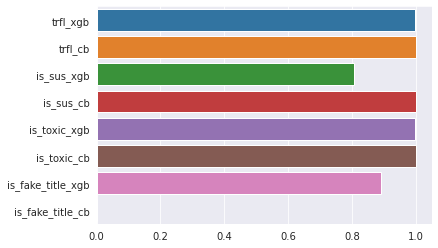

In [57]:
import  seaborn as sns
df = pd.DataFrame(columns=['trfl_xgb','trfl_cb','is_sus_xgb','is_sus_cb','is_toxic_xgb','is_toxic_cb','is_fake_title_xgb','is_fake_title_cb'])
df.loc[len(df.index)] = [0.9984023  ,1.       ,  0.80716062 ,1.      ,   0.99954754 ,1.,
 0.89311844, 0.        ]
print(df)
sums = df.sum()

# plot sums
sns.barplot(y=sums.index, x=sums.values, orient='h')

0.5806847534480295

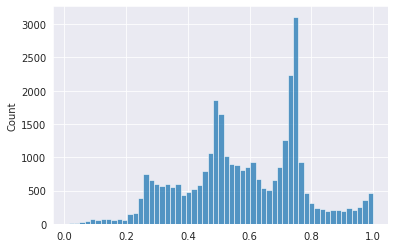

In [17]:
import seaborn as sns
sns.histplot(avg)

np.mean(avg)

KeyboardInterrupt: 

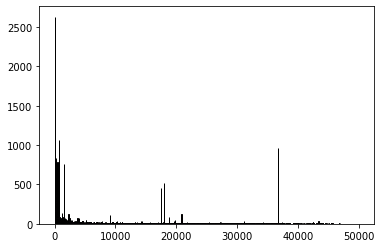

In [139]:
sns.histplot(X_test)

<AxesSubplot:ylabel='Count'>

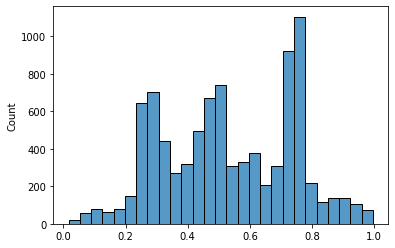

In [90]:
sns.histplot(X_train)

In [ ]:
appeared refusal concede late last night (via John Podesta), followed Trump’s victory speech, referred concession call opponent, Hillary Clinton finally issued concession speech around 11:30 Eastern time. tone clearly bitter, though cloaked hopeful language continued efforts. questions whether Donald Trump would wherewithal admit defeat accept election results, turned Hillary apparent difficulty giving up. SEE: Something Wrong Hillary? Concede Tonight – Refuses Speak Crowd – Health Episode? reality set in, went stage, albeit hour scheduled so, admit loss. played might largest enthusiastic crowd date 2016 campaign trail. Partial transcript: Thank much here. love all, too. Last night congratulated Donald Trump offered work behalf country. hope successful president Americans. outcome wanted worked hard for, I’m sorry win election values share vision hold country. feel pride gratitude wonderful campaign built together. vast diverse creative unruly energized campaign. represent best America candidate one greatest honors life. know disappointed feel feel it, too. tens millions Americans invested hopes dreams effort. painful, long time. want remember this. campaign never one person, even one election. country love building America hopeful, inclusive, big-hearted. seen nation deeply divided thought. still believe America, always will. do, must accept result look future. Donald Trump going president. owe open mind chance lead. constitutional democracy enshrines peaceful transfer power. […] anyone sent contributions, even small $5, kept us going, thank you. us, young people particular, hope hear — have, Tim said, spent entire life fighting believe in. I’ve successes setbacks sometimes painful ones. Many beginning professional, public, political careers — successes setbacks too. loss hurts, please never stop believing fighting what’s right worth it. […] need — need keep fights rest lives. women, especially young women, put faith campaign me: want know nothing made prouder champion. Now, know still shattered highest hardest glass ceiling, someday someone — hopefully sooner might think right now. [Cheers applause] little girls watching this, never doubt valuable powerful deserving every chance opportunity world pursue achieve dreams. [Cheers applause] Hillary Finally Concedes: “This Painful Long Time” [0.50082976 1.         0.26190835 0.         0.80097264 1.
 0.8566556  1.        ] 0

In [ ]:
in: Government Petitions Special Interests rigged investigation new batch Hillary Clinton-related emails got epically rigged. Well, folks research Zero Hedge completely outdone discovery never reach mainstream. “Ironically”, Peter Kadzik proven “impartiality” multiple WikiLeaks emails including newly released bombshell Kadzik provides helpful “heads up” Hillary’s email server investigation. Kadzik emailed John Podesta (via gmail) May 19, 2015: HJC oversight hearing today head Civil Division testify. Likely get questions State Department emails. Another filing FOIA case went last night go indicates awhile (2016) State Department posts emails. Perhaps Mr. Kadzik could explain readers – American public – particular message delivered via private, gmail account rather official DOJ email account? Go r ead article learn Kadzik’s background It’s positively incestuous ties Clintons Podestas. Here’s do. Contact Department Justice. civil screaming, swearing, threatening never accomplished anything. Let know want see independent investigation emails Clinton Foundation. Let know also contacting local media make aware conflict interest. contact information DoJ. Make phone calls send emails. Department Comment Line: 202-353-1555 Department Justice Main Switchboard: 202-514-2000 Executive Office United States Attorneys Main Line – (202) 514-2000 DoJ Criminal Investigation email address: [email protected] Feel free use email template: RE: Peter Kadzik learned close connections Peter Kadzik Hillary Clinton, appalled would charge new investigation emails. way reflect well DoJ. It’s insult American people blatant collusion allowed presented “justice.” especially appalling considering email sent Podesta last investigation subject line “Heads up” notifying local media debacle sharing everywhere reach via social media. People learning collusion rapidly – might want read article published Zero Hedge put front page Drudge Report – keeping mind Drudge gets millions page views per day one biggest websites America. American people don’t trust government anymore, actions like this, putting John Podesta’s close friend charge investigation eyes on, like spitting face every person America hopes justice indeed blind, even recipient Hillary Rodham Clinton. Please right thing. investigation needs independent anyone ties Clintons figure campaign. Sincerely, use social media, get it. Share article one Zero Hedge shut mission accomplished. don’t use social media, forward emails everyone address book. you’re computer reading this, I’m pretty sure email too. Contact local media letters editor, comments websites, phone calls anyone listen. sit nothing, get nothing. time stand corruption. time voice heard. Make count. Article first posted DaisyLuther.com Submit review Rigged Investigation Hillary Clinton [0.99963582 1.         0.01031697 0.         0.63430244 1.
 0.98267382 1.        ] 1

In [58]:
""":16-Years-Old smdh. He’s Child. Andrew Anglin October 27, 2016 Click enlarge I’ve said long time now, appears Neo-Nazi satirists infiltrated Jewish media using positions mock insane depths Jew lies sunk. Seriously, running Guardian, would absolutely run cover: picture 40-something Negro crying, headline he’s child caption saying he’s 16-years-old. going push this, would print lyrics Eric Clapton’s “Tears Heaven” sidebar. predicting going use song video Calais migrants go French Nazis burned camp. rather, burned camp French Nazis told leave “their tradition” IRL quote French official burn homes leave them. Would know name saw heaven? Would saw heaven? must strong‘Cause know don’t belong heaven Would hold hand saw heaven? Would help stand saw heaven? I’ll find way night day‘Cause know can’t stay heaven Time bring Time bend knees Time break heart begging please, begging please Beyond door There’s peace I’m sure know there’ll Tears heaven Would know name saw heaven? Would saw heaven? must strong‘Cause know don’t belong heaven 16-Years-Old smdh. He’s Child. м 1"""
@user so you're saying women who got the healthcare they needed is comparable to people killed in #orlando &amp; #sandyhook   [9.85958993e-01 1.00000000e+00 3.15010780e-03 0.00000000e+00
 3.40003811e-04 0.00000000e+00 2.01754317e-01 0.00000000e+00] 0
âthe truth is rarely pure and never simple.â #friend #friends #fun #funny #love #instagood #friendship #pay #chill   #cute #photooftâ¦ [8.68266225e-01 1.00000000e+00 2.98909068e-01 0.00000000e+00
 2.29828176e-04 0.00000000e+00 9.92846549e-01 1.00000000e+00] 0
@STACCS_WNT_FOLD you tell me, coon. [0.93613917 1.         0.01052785 0.         0.9958455  1.
 0.98552632 1.        ] 1

SyntaxError: invalid syntax (953920514.py, line 1)

ValueError: cannot set a row with mismatched columns